<a href="https://colab.research.google.com/github/technophille/technophille/blob/main/WEIGHTED_ANTELLIGENCE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)




In [ ]:
#Importing Training data from google drive and saving as eqdata
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/ANTELLIGENCE/data/Dataset.xlsx'
eqdata = pd.read_excel(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
URL = "https://antelligence-proto-default-rtdb.firebaseio.com/antelligence/live.json"
response = requests.get(URL)
firebase_data = response.json()

live_steps = float(firebase_data['steps_last_minute'])

live_df = pd.DataFrame({
    "cow_sum_mean":   [live_steps],
    "dog_sum_mean":   [live_steps * np.random.uniform(0.8, 1.1)],
    "sheep_sum_mean": [live_steps * np.random.uniform(0.6, 1.0)]
})

X_live = live_df.copy()



In [ ]:
#making x as sum mean and on y it is the EQ result
# Remove missing values
eqdata = eqdata.dropna(subset=[
    'cow_sum_mean',
    'dog_sum_mean',
    'sheep_sum_mean',
    'EQ'
])

X = eqdata[['cow_sum_mean','dog_sum_mean','sheep_sum_mean']]
y = eqdata['EQ']



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf.fit(X_train, y_train)

# Isolation Forest (train on NORMAL behavior)
X_normal = eqdata[eqdata['EQ'] == 0][
    ['cow_sum_mean','dog_sum_mean','sheep_sum_mean']
]

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)
iso_forest.fit(X_normal)



IsolationForest(contamination=0.05, n_estimators=200, random_state=42)

In [36]:
# Anomaly Detection
anomaly_label = iso_forest.predict(X_live)[0]   # -1 or 1
anomaly_flag = 1 if anomaly_label == -1 else 0

# Logistic Regression
lr_prob = logreg.predict_proba(X_live)[0][1]

# Random Forest
rf_prob = rf.predict_proba(X_live)[0][1]

# Weighted Ensemble
final_score = (
    0.4 * lr_prob +
    0.4 * rf_prob +
    0.2 * anomaly_flag
)

print("LR Prob:", lr_prob)
print("RF Prob:", rf_prob)
print("Anomaly:", anomaly_flag)
print("Final Score:", final_score)


LR Prob: 0.0960062427385146
RF Prob: 0.3570518640306606
Anomaly: 0
Final Score: 0.1812232427076701


In [39]:
y_pred_lr = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)

metrics_table = pd.DataFrame(columns=[
    "Model","Accuracy","Precision","Recall","F1 Score"
])

# Logistic Regression
metrics_table.loc[len(metrics_table)] = [
    "Logistic Regression",
    accuracy_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_lr)
]

# Random Forest
metrics_table.loc[len(metrics_table)] = [
    "Random Forest",
    accuracy_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_rf)
]

# Ensemble
lr_prob_test = logreg.predict_proba(X_test)[:,1]
rf_prob_test = rf.predict_proba(X_test)[:,1]

ensemble_prob = 0.5*lr_prob_test + 0.5*rf_prob_test
ensemble_pred = (ensemble_prob >= 0.5).astype(int)

metrics_table.loc[len(metrics_table)] = [
    "Weighted Ensemble",
    accuracy_score(y_test, ensemble_pred),
    precision_score(y_test, ensemble_pred),
    recall_score(y_test, ensemble_pred),
    f1_score(y_test, ensemble_pred)
]

metrics_table


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.862816,0.619048,0.094203,0.163522
1,Random Forest,0.872099,0.780000,0.141304,0.239264
2,Weighted Ensemble,0.872099,0.769231,0.144928,0.243902


In [40]:
lr_prob = logreg.predict_proba(X_test)[:,1]
rf_prob = rf.predict_proba(X_test)[:,1]

ensemble_prob = 0.5*lr_prob + 0.5*rf_prob
ensemble_pred = (ensemble_prob >= 0.5).astype(int)

ens_accuracy  = accuracy_score(y_test, ensemble_pred)
ens_precision = precision_score(y_test, ensemble_pred)
ens_recall    = recall_score(y_test, ensemble_pred)
ens_f1        = f1_score(y_test, ensemble_pred)

metrics_table = metrics_table._append({
    "Model": "Weighted Ensemble",
    "Accuracy": ens_accuracy,
    "Precision": ens_precision,
    "Recall": ens_recall,
    "F1 Score": ens_f1
}, ignore_index=True)

metrics_table





,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.862816,0.619048,0.094203,0.163522
1,Random Forest,0.872099,0.780000,0.141304,0.239264
2,Weighted Ensemble,0.872099,0.769231,0.144928,0.243902
3,Weighted Ensemble,0.872099,0.769231,0.144928,0.243902


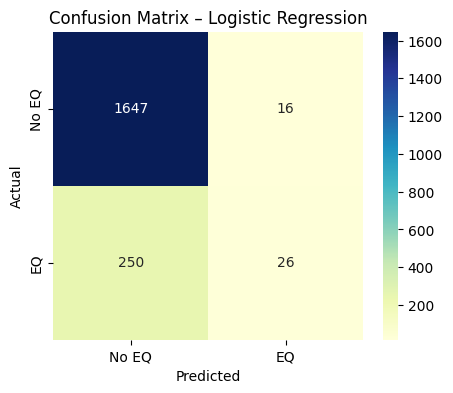

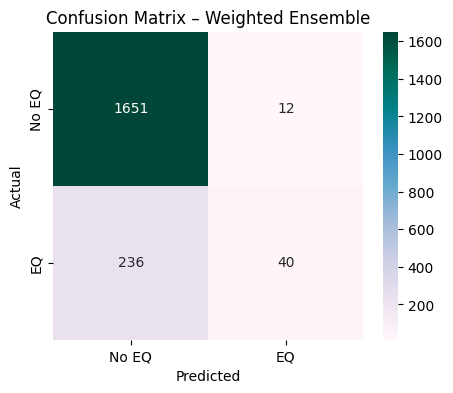

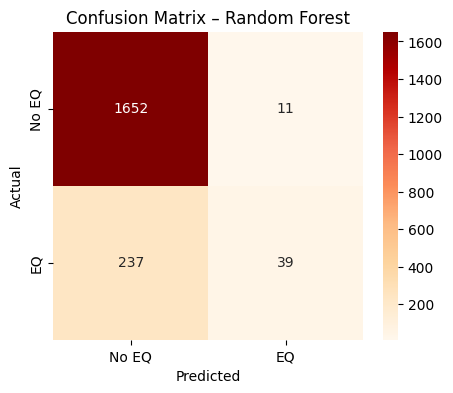

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm_ens = confusion_matrix(y_test, ensemble_pred)

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['No EQ', 'EQ'],
            yticklabels=['No EQ', 'EQ'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()



plt.figure(figsize=(5,4))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=['No EQ', 'EQ'],
            yticklabels=['No EQ', 'EQ'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Weighted Ensemble")
plt.show()

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['No EQ', 'EQ'],
            yticklabels=['No EQ', 'EQ'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()



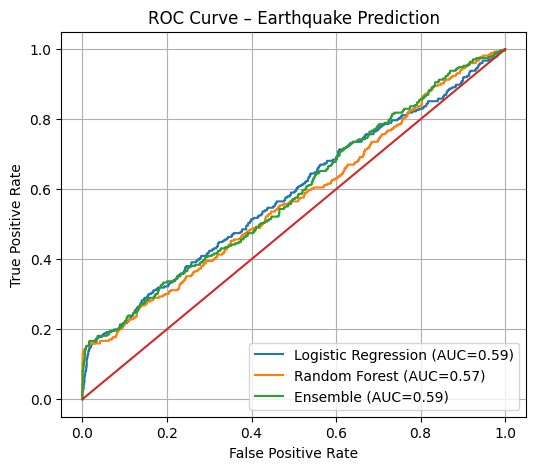

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
auc_lr = roc_auc_score(y_test, lr_prob)


fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
auc_rf = roc_auc_score(y_test, rf_prob)

fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_prob)
auc_ens = roc_auc_score(y_test, ensemble_prob)


plt.figure(figsize=(6,5))

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.2f})')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC={auc_ens:.2f})')

plt.plot([0,1], [0,1],)  # random classifier line

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Earthquake Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()
